# Introduction
<b>Dataset</b> ["Dogs vs. Cats"](https://www.kaggle.com/c/dogs-vs-cats/data) image classification problem on Kaggle:
- Train data sets include 25,000 images: 12,500 images of dogs and 12,500 images of cats.
- Test data sets has 12,500 unlabeled images
- Raw images have different sizes

<b>Approach</b>
- 1st network with 2 conv layer nn: encounter high bias issue
    + Probably need a bigger (more layers) network
    + Probably need to train longer
- 2nd network with 4 conv layer nn. 
    + Probably need more data: augumented training dataset to overcome overfitting
    + Probably regularization might help





## Explore the data

#### Import libraries

In [1]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import os
import zipfile
import glob

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint  # Note: ModelCheckpoint is imported from tf.keras.callbacks (not keras.callbacks)
                                                        # so that both the model and the callbacks from tf.keras (if one from tf.keras and one from keras, there will be an error)


import numpy as np
import random

In [2]:
!ls ../

input  lib  src  working


#### Split training data into train and validation (80%-20%), i.e., 10k for train and 2.5k for validation

In [3]:
kaggle_train_dir = '../input/train/train/'
kaggle_test_dir = '../input/test1/test1'
base_dir = '../cats_dogs'
    
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# training folder
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation folder
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    
if not os.path.exists(train_dir):
    print("Copy images to train/cats and train/dogs")
    os.makedirs(train_dir)
    os.makedirs(train_cats_dir)
    os.makedirs(train_dogs_dir)
    !cp -r {kaggle_train_dir}/cat* {train_cats_dir}
    !ls {train_cats_dir} | wc -l
    !cp -r {kaggle_train_dir}/dog* {train_dogs_dir}
    !ls {train_dogs_dir} | wc -l

if not os.path.exists(validation_dir):
    print("Prepare validation directories")
    os.makedirs(validation_dir)
    os.makedirs(validation_cats_dir)
    os.makedirs(validation_dogs_dir)

if not os.path.exists(test_dir):
    print("Copy images to test directory")
    os.makedirs(test_dir)
    !cp -r {kaggle_test_dir}/* {test_dir}

Copy images to train/cats and train/dogs
12500
12500
Prepare validation directories
Copy images to test directory


In [4]:
# Split the train data into train and validation sets. Only moving the file from train to val dir once.
validation_cat_fn = glob.glob(validation_cats_dir + '/*') #glob.glob instead of os.listdir
validation_dog_fn = glob.glob(validation_dogs_dir + '/*')
if len(validation_cat_fn)==0 or len(validation_dog_fn)==0:
    #split 80%-20%
    idx_train, idx_validation = train_test_split(range(12500), test_size=.2, random_state=42) 
    train_cat_fn = glob.glob(train_cats_dir + '/*')
    train_dog_fn = glob.glob(train_dogs_dir + '/*')
    for i in idx_validation:
        os.rename(train_cat_fn[i], train_cat_fn[i].replace('train', 'validation'))
        os.rename(train_dog_fn[i], train_dog_fn[i].replace('train', 'validation'))

In [5]:
#### Skim through the train and validation folders
train_cat_fn = os.listdir(train_cats_dir)
train_dog_fn = os.listdir(train_dogs_dir)

print(train_cat_fn[:10])
print(train_dog_fn[:10])

print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

['cat.9803.jpg', 'cat.8375.jpg', 'cat.918.jpg', 'cat.7264.jpg', 'cat.1123.jpg', 'cat.3255.jpg', 'cat.535.jpg', 'cat.11625.jpg', 'cat.4766.jpg', 'cat.6206.jpg']
['dog.1178.jpg', 'dog.7845.jpg', 'dog.814.jpg', 'dog.2066.jpg', 'dog.8575.jpg', 'dog.1444.jpg', 'dog.11532.jpg', 'dog.10033.jpg', 'dog.4134.jpg', 'dog.5553.jpg']
total training cat images : 10000
total training dog images : 10000
total validation cat images : 2500
total validation dog images : 2500


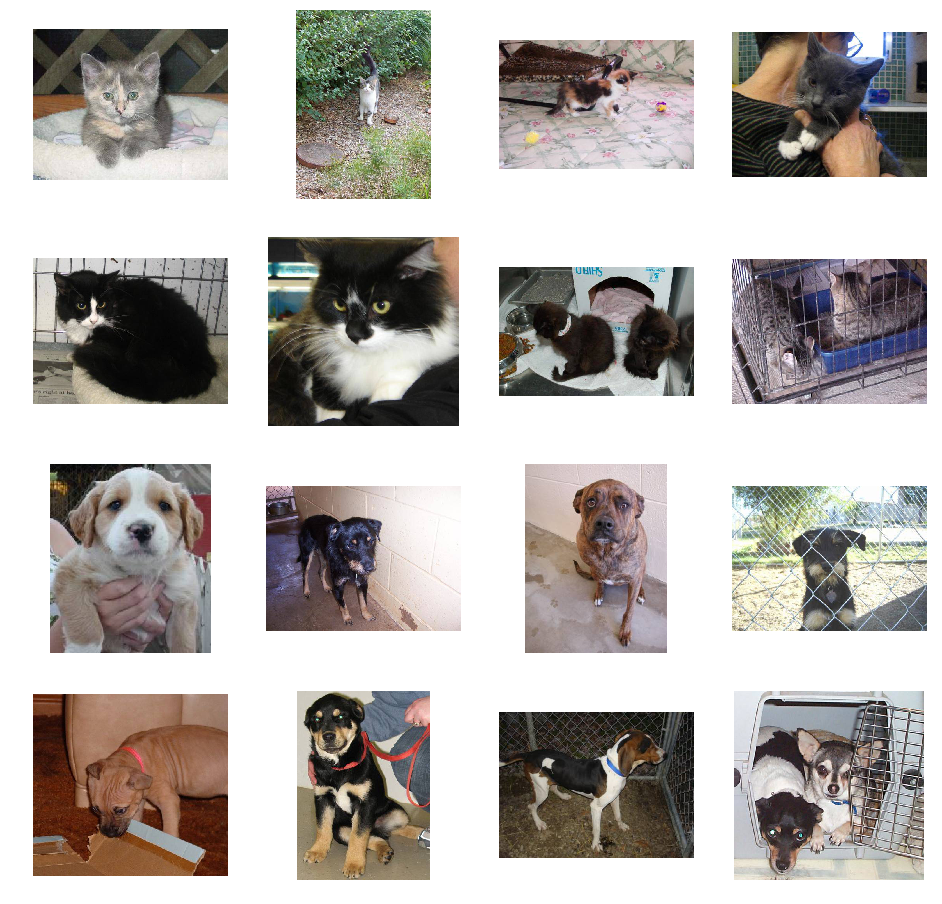

In [6]:
#### Display a batch of 8 cat and 8 dog pictures.
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 4
ncols = 4

pic_index = 20 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fn[pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fn[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()



#### Data Preprocessing
Using keras.preprocessing.image.ImageDataGenerator to resize and rescale. Labels are automatically assigned based on directory names.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
val_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))   

# Flow validation images in batches of 20 using val_datagen generator
val_generator =  val_datagen.flow_from_directory(validation_dir,
                                                 batch_size=20,
                                                 class_mode  = 'binary',
                                                 target_size = (150, 150))


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Building a small CNN with Keras
Build a cnn with 2 convolutional layers with 16 and 32 convolutions respectively.

    

In [8]:
#### Define the model

model2 = tf.keras.models.Sequential([
    # the input shape: the desired size of the image 150x150 with 3 color channel RGB
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')# 1 output neuron. Sigmoid: where 0 for 1 class ('cats') and 1 for the other ('dogs')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               21234176  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [9]:
model2.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [10]:
model_dir = os.path.join(base_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
file_name = os.path.join(model_dir, 'model_2conv.h5')

if not os.path.exists(file_name):
    # checkpoint
    checkpointpath = file_name[:-3] + "-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(checkpointpath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', period=20)
    callbacks_list = [checkpoint]
    # Fit the model
    history2 = model2.fit_generator(train_generator,
                                    validation_data=val_generator,
                                    steps_per_epoch=10,
                                    epochs=200,
                                    validation_steps=50,
                                    callbacks = callbacks_list,
                                    verbose=2)
    model2.save(file_name)
else:
    model2.load_weights(file_name)

Epoch 1/200
10/10 - 7s - loss: 5.0529 - acc: 0.5050 - val_loss: 1.1682 - val_acc: 0.5150
Epoch 2/200
10/10 - 3s - loss: 0.8199 - acc: 0.4750 - val_loss: 0.7265 - val_acc: 0.4860
Epoch 3/200
10/10 - 3s - loss: 0.6822 - acc: 0.5700 - val_loss: 0.6844 - val_acc: 0.5320
Epoch 4/200
10/10 - 3s - loss: 0.6814 - acc: 0.5500 - val_loss: 0.7630 - val_acc: 0.4880
Epoch 5/200
10/10 - 3s - loss: 0.6845 - acc: 0.5550 - val_loss: 0.7467 - val_acc: 0.5220
Epoch 6/200
10/10 - 3s - loss: 0.6608 - acc: 0.6150 - val_loss: 0.7143 - val_acc: 0.5040
Epoch 7/200
10/10 - 3s - loss: 0.6946 - acc: 0.5250 - val_loss: 0.6476 - val_acc: 0.6470
Epoch 8/200
10/10 - 3s - loss: 0.6735 - acc: 0.6500 - val_loss: 0.6471 - val_acc: 0.6370
Epoch 9/200
10/10 - 3s - loss: 0.6674 - acc: 0.6150 - val_loss: 0.6358 - val_acc: 0.6400
Epoch 10/200
10/10 - 3s - loss: 0.6728 - acc: 0.6000 - val_loss: 0.6319 - val_acc: 0.6760
Epoch 11/200
10/10 - 3s - loss: 0.6536 - acc: 0.6750 - val_loss: 0.6514 - val_acc: 0.5750
Epoch 12/200
10/10 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


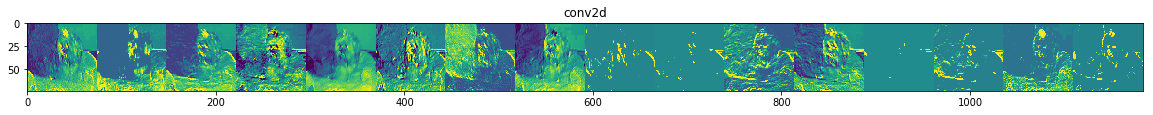

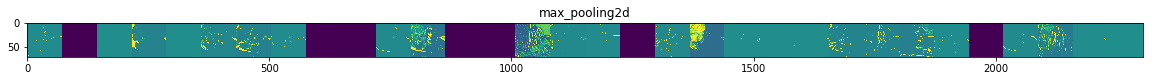

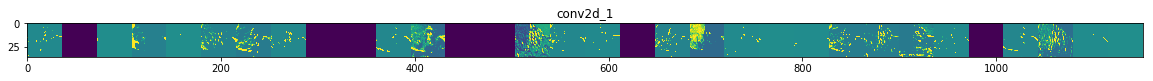

In [11]:
#### Visualize intermediate representations

# intermediate representations for all layers in the previous model after the first (which is the input examples).
successive_outputs = [layer.output for layer in model2.layers[1:]]

# a new model for visualization
visualization_model = tf.keras.models.Model(inputs = model2.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fn]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fn]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150)) 
x = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
x /= 255.0    # Rescale by 1/255

# Run the image through the visualization network, thus obtaining all intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# names of the layers
layer_names = [layer.name for layer in model2.layers]

# Visualize intermediate representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4: #Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
        # the big matrix for displaying all features (of the same layer) at once
        display_grid = np.zeros((size, size * n_features))
    
        # scale for display
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter output into a horizontal grid

    
        # Display
        scale = 20./n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis' ) 

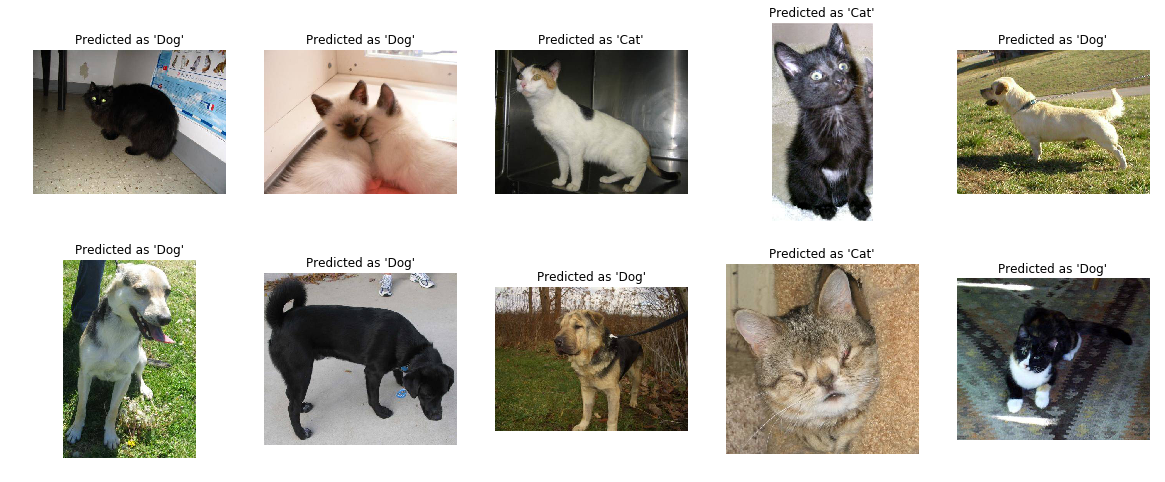

In [12]:
#### Use the trained model to predict 'new' images

# Randomly select 10 images from test directory
rep = 10
images = []
pred_fn = random.sample(os.listdir(test_dir), rep)
for fn in pred_fn:
    img = load_img(os.path.join(test_dir, fn), target_size=(150, 150))
    img = img_to_array(img)
    #img = np.expand_dims(img, axis=0)
    images.append(img)
images = np.array(images)
pred_classes = model2.predict(images, batch_size=10)



# Display the test images and its predicted labels
fig = plt.gcf()
ncols, nrows = 5, 2
fig.set_size_inches(ncols*4, nrows*4)
for i, fn in enumerate(pred_fn):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(os.path.join(test_dir, fn))
    plt.imshow(img)
    pred_lab = "Dog" if pred_classes[i]>.5 else "Cat"
    plt.title("Predicted as '{}'".format(pred_lab))

plt.show()

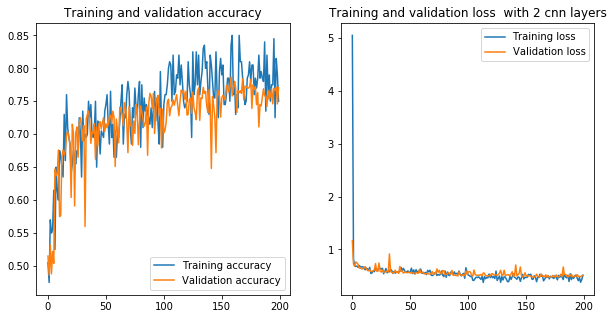

In [13]:
#### Evaluate accuracy and loss for the model
# Retrieve a list of acc/loss results on training and validation data sets for each training epoch
acc      = history2.history[     'acc' ]
val_acc  = history2.history[ 'val_acc' ]
loss     = history2.history[    'loss' ]
val_loss = history2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, label='Training accuracy')
axes[0].plot(epochs, val_acc, label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, label='Training loss')
axes[1].plot(epochs, val_loss, label='Validation loss')
axes[1].set_title('Training and validation loss  with 2 cnn layers')
axes[1].legend()

### Remark:
Train and validation accuracy are almost equal and they gradually level off around epoch = 100 and the overall accuracy is only around 80% --> high bias issue --> try to remedy this by increasing the number of hidden layer in the CNN.

## Build a bigger CNN
Build a cnn with 4 convolutional layers with 32, 64, 128 and 128 convolutions respectively.

In [14]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(loss='binary_crossentropy',
               optimizer=RMSprop(lr=1e-4),
               metrics=['acc'])


#### Train the model

file_name = os.path.join(model_dir, 'model_4conv.h5')
if not os.path.exists(file_name):
    # checkpoint
    checkpointpath = file_name[:-3] + "-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(checkpointpath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', period=7)
    callbacks_list = [checkpoint]
    # Fit the model
    history4 = model4.fit_generator(train_generator,
                                    validation_data=val_generator,
                                    steps_per_epoch=200,
                                    epochs=70,
                                    validation_steps=150,
                                    callbacks = callbacks_list,
                                    verbose=2)
    model4.save(file_name)

Epoch 1/70
200/200 - 21s - loss: 0.6839 - acc: 0.5468 - val_loss: 0.6729 - val_acc: 0.5550
Epoch 2/70
200/200 - 18s - loss: 0.6275 - acc: 0.6530 - val_loss: 0.6072 - val_acc: 0.6600
Epoch 3/70
200/200 - 18s - loss: 0.5805 - acc: 0.6955 - val_loss: 0.5433 - val_acc: 0.7300
Epoch 4/70
200/200 - 18s - loss: 0.5481 - acc: 0.7193 - val_loss: 0.5362 - val_acc: 0.7283
Epoch 5/70
200/200 - 18s - loss: 0.5351 - acc: 0.7245 - val_loss: 0.5179 - val_acc: 0.7460
Epoch 6/70
200/200 - 18s - loss: 0.5105 - acc: 0.7520 - val_loss: 0.4962 - val_acc: 0.7527
Epoch 7/70

Epoch 00007: saving model to ../cats_dogs/model/model_4conv-07-0.78.hdf5
200/200 - 18s - loss: 0.4961 - acc: 0.7575 - val_loss: 0.4742 - val_acc: 0.7763
Epoch 8/70
200/200 - 18s - loss: 0.4882 - acc: 0.7640 - val_loss: 0.4710 - val_acc: 0.7720
Epoch 9/70
200/200 - 18s - loss: 0.4616 - acc: 0.7797 - val_loss: 0.4549 - val_acc: 0.7833
Epoch 10/70
200/200 - 18s - loss: 0.4643 - acc: 0.7785 - val_loss: 0.4681 - val_acc: 0.7693
Epoch 11/70
200

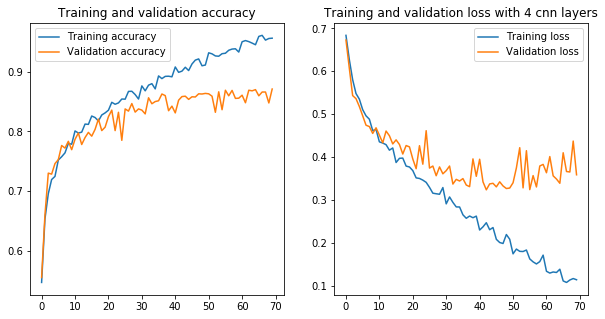

In [15]:
# Learning curve

import matplotlib.pyplot as plt
acc = history4.history['acc'] 
val_acc = history4.history['val_acc'] 
loss = history4.history['loss'] 
val_loss = history4.history['val_loss'] 

epochs   = range(len(acc)) # Get number of epochs

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, label='Training accuracy')
axes[0].plot(epochs, val_acc, label='Validation accuracy')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, label='Training loss')
axes[1].plot(epochs, val_loss, label='Validation loss')
axes[1].set_title('Training and validation loss with 4 cnn layers')
axes[1].legend()

### Remarks:
Around epoch = 35, validation accuracy levels off although train accuracy keeps improving --> we have overfitting issue --> try to remedy this by:
1. Reduce the number of epoch
2. Increase the number of training samples by image augmentation


## Image augmentation: increase number of training examples

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

val_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
val_generator = val_datagen.flow_from_directory(validation_dir,
                                                batch_size=100,
                                                class_mode='binary',
                                                target_size=(150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [17]:
#### Train the model

file_name = os.path.join(model_dir, 'model_4conv_augment.h5')
if not os.path.exists(file_name):
    # checkpoint
    checkpointpath = file_name[:-3] + "-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(checkpointpath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', period=5)
    callbacks_list = [checkpoint]
    # Fit the model
    history4_aug = model4.fit_generator(train_generator,
                                    validation_data=val_generator,
                                    steps_per_epoch=200,
                                    epochs=60,
                                    validation_steps=150,
                                    callbacks = callbacks_list,
                                    verbose=2)
    model4.save(file_name)

Epoch 1/60
200/200 - 228s - loss: 0.4644 - acc: 0.7844 - val_loss: 0.4481 - val_acc: 0.7941
Epoch 2/60
200/200 - 220s - loss: 0.4287 - acc: 0.8027 - val_loss: 0.4247 - val_acc: 0.8046
Epoch 3/60
200/200 - 222s - loss: 0.4157 - acc: 0.8080 - val_loss: 0.4323 - val_acc: 0.8015
Epoch 4/60
200/200 - 222s - loss: 0.4007 - acc: 0.8159 - val_loss: 0.4007 - val_acc: 0.8163
Epoch 5/60

Epoch 00005: saving model to ../cats_dogs/model/model_4conv_augment-05-0.82.hdf5
200/200 - 221s - loss: 0.3915 - acc: 0.8236 - val_loss: 0.4045 - val_acc: 0.8155
Epoch 6/60
200/200 - 222s - loss: 0.3829 - acc: 0.8260 - val_loss: 0.4417 - val_acc: 0.7965
Epoch 7/60
200/200 - 222s - loss: 0.3817 - acc: 0.8296 - val_loss: 0.4125 - val_acc: 0.8076
Epoch 8/60
200/200 - 221s - loss: 0.3704 - acc: 0.8356 - val_loss: 0.3761 - val_acc: 0.8333
Epoch 9/60
200/200 - 221s - loss: 0.3689 - acc: 0.8353 - val_loss: 0.3906 - val_acc: 0.8244
Epoch 10/60

Epoch 00010: saving model to ../cats_dogs/model/model_4conv_augment-10-0.83.h

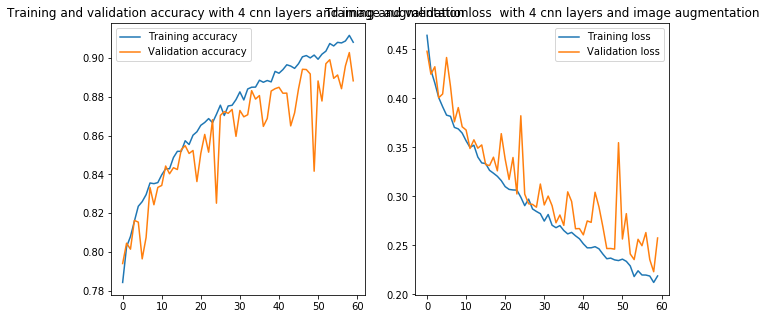

In [18]:
# Learning curve

import matplotlib.pyplot as plt
acc = history4_aug.history['acc'] 
val_acc = history4_aug.history['val_acc'] 
loss = history4_aug.history['loss'] 
val_loss = history4_aug.history['val_loss'] 

epochs   = range(len(acc)) # Get number of epochs

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, label='Training accuracy')
axes[0].plot(epochs, val_acc, label='Validation accuracy')
axes[0].set_title('Training and validation accuracy with 4 cnn layers and image augmentation')
axes[0].legend()

axes[1].plot(epochs, loss, label='Training loss')
axes[1].plot(epochs, val_loss, label='Validation loss')
axes[1].set_title('Training and validation loss  with 4 cnn layers and image augmentation')
axes[1].legend()